# Estimate scavenging rates from observations

Dissolved trace metal data from Manuel Colombo, particulate trace metal data from Jingxuan Li.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
import seaborn as sns; sns.set()
import netCDF4 as nc
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from scipy.signal import savgol_filter
import pickle
from mpl_toolkits.basemap import Basemap, cm
import matplotlib
import cmocean

warnings.filterwarnings('ignore')

%matplotlib notebook

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load files:

In [4]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

dPb_LS2 = Pb_data['LS2'][np.isfinite(Pb_data['LS2'])].astype('float')
dPb_BB1 = Pb_data['BB1'][np.isfinite(Pb_data['BB1'])].astype('float')
dPb_BB2 = Pb_data['BB2'][np.isfinite(Pb_data['BB2'])].astype('float')
dPb_BB3 = Pb_data['BB3'][np.isfinite(Pb_data['BB3'])].astype('float')
dPb_CB1 = Pb_data['CB1'][np.isfinite(Pb_data['CB1'])].astype('float')
dPb_CB2 = Pb_data['CB2'][np.isfinite(Pb_data['CB2'])].astype('float')
dPb_CB3 = Pb_data['CB3'][np.isfinite(Pb_data['CB3'])].astype('float')
dPb_CB4 = Pb_data['CB4'][np.isfinite(Pb_data['CB4'])].astype('float')
dPb_CAA1 = Pb_data['CAA1'][np.isfinite(Pb_data['CAA1'])].astype('float')
dPb_CAA3 = Pb_data['CAA3'][np.isfinite(Pb_data['CAA3'])].astype('float')
dPb_CAA4 = Pb_data['CAA4'][np.isfinite(Pb_data['CAA4'])].astype('float')
dPb_CAA5 = Pb_data['CAA5'][np.isfinite(Pb_data['CAA5'])].astype('float')
dPb_CAA6 = Pb_data['CAA6'][np.isfinite(Pb_data['CAA6'])].astype('float')
dPb_CAA7 = Pb_data['CAA7'][np.isfinite(Pb_data['CAA7'])].astype('float')
dPb_CAA8 = Pb_data['CAA8'][np.isfinite(Pb_data['CAA8'])].astype('float')

depth_LS2 = Pb_data['Depth'][np.isfinite(Pb_data['LS2'])].astype('float')
depth_BB1 = Pb_data['Depth.1'][np.isfinite(Pb_data['BB1'])].astype('float')
depth_BB2 = Pb_data['Depth.2'][np.isfinite(Pb_data['BB2'])].astype('float')
depth_BB3 = Pb_data['Depth.3'][np.isfinite(Pb_data['BB3'])].astype('float')
depth_CB1 = Pb_data['Depth.13'][np.isfinite(Pb_data['CB1'])].astype('float')
depth_CB2 = Pb_data['Depth.14'][np.isfinite(Pb_data['CB2'])].astype('float')
depth_CB3 = Pb_data['Depth.15'][np.isfinite(Pb_data['CB3'])].astype('float')
depth_CB4 = Pb_data['Depth.16'][np.isfinite(Pb_data['CB4'])].astype('float')
depth_CAA1 = Pb_data['Depth.4'][np.isfinite(Pb_data['CAA1'])].astype('float')
depth_CAA3 = Pb_data['Depth.6'][np.isfinite(Pb_data['CAA3'])].astype('float')
depth_CAA4 = Pb_data['Depth.7'][np.isfinite(Pb_data['CAA4'])].astype('float')
depth_CAA5 = Pb_data['Depth.8'][np.isfinite(Pb_data['CAA5'])].astype('float')
depth_CAA6 = Pb_data['Depth.9'][np.isfinite(Pb_data['CAA6'])].astype('float')
depth_CAA7 = Pb_data['Depth.10'][np.isfinite(Pb_data['CAA7'])].astype('float')
depth_CAA8 = Pb_data['Depth.11'][np.isfinite(Pb_data['CAA8'])].astype('float')

In [5]:
stn_names = Pb_data['Station names'].dropna().astype('str')
lons = Pb_data['station lon'].astype('float').dropna().values
lats = Pb_data['Station lat'].astype('float').dropna().values

In [6]:
# Combine all observations into single collapsed arrays:

obs_depths = np.concatenate((depth_LS2, depth_BB1, depth_BB2, depth_BB3, depth_CAA1, depth_CAA3, depth_CAA4, \
                             depth_CAA5, depth_CAA6, depth_CAA7, depth_CAA8, depth_CB1, depth_CB2, \
                             depth_CB3, depth_CB4))

obs_lons = np.concatenate((np.ones(depth_LS2.shape)*lons[stn_names=='LS2'], \
                           np.ones(depth_BB1.shape)*lons[stn_names=='BB1'], \
                           np.ones(depth_BB2.shape)*lons[stn_names=='BB2'], \
                           np.ones(depth_BB3.shape)*lons[stn_names=='BB3'], \
                           np.ones(depth_CAA1.shape)*lons[stn_names=='CAA1'], \
                           np.ones(depth_CAA3.shape)*lons[stn_names=='CAA3'], \
                           np.ones(depth_CAA4.shape)*lons[stn_names=='CAA4'], \
                           np.ones(depth_CAA5.shape)*lons[stn_names=='CAA5'], \
                           np.ones(depth_CAA6.shape)*lons[stn_names=='CAA6'], \
                           np.ones(depth_CAA7.shape)*lons[stn_names=='CAA7'], \
                           np.ones(depth_CAA8.shape)*lons[stn_names=='CAA8'], \
                           np.ones(depth_CB1.shape)*lons[stn_names=='CB1'], \
                           np.ones(depth_CB2.shape)*lons[stn_names=='CB2'], \
                           np.ones(depth_CB3.shape)*lons[stn_names=='CB3'], \
                           np.ones(depth_CB4.shape)*lons[stn_names=='CB4']))

obs_lats = np.concatenate((np.ones(depth_LS2.shape)*lats[stn_names=='LS2'], \
                           np.ones(depth_BB1.shape)*lats[stn_names=='BB1'], \
                           np.ones(depth_BB2.shape)*lats[stn_names=='BB2'], \
                           np.ones(depth_BB3.shape)*lats[stn_names=='BB3'], \
                           np.ones(depth_CAA1.shape)*lats[stn_names=='CAA1'], \
                           np.ones(depth_CAA3.shape)*lats[stn_names=='CAA3'], \
                           np.ones(depth_CAA4.shape)*lats[stn_names=='CAA4'], \
                           np.ones(depth_CAA5.shape)*lats[stn_names=='CAA5'], \
                           np.ones(depth_CAA6.shape)*lats[stn_names=='CAA6'], \
                           np.ones(depth_CAA7.shape)*lats[stn_names=='CAA7'], \
                           np.ones(depth_CAA8.shape)*lats[stn_names=='CAA8'], \
                           np.ones(depth_CB1.shape)*lats[stn_names=='CB1'], \
                           np.ones(depth_CB2.shape)*lats[stn_names=='CB2'], \
                           np.ones(depth_CB3.shape)*lats[stn_names=='CB3'], \
                           np.ones(depth_CB4.shape)*lats[stn_names=='CB4']))

obs_dPb = np.concatenate((dPb_LS2, dPb_BB1, dPb_BB2, dPb_BB3, dPb_CAA1, dPb_CAA3, dPb_CAA4, \
                         dPb_CAA5, dPb_CAA6, dPb_CAA7, dPb_CAA8, dPb_CB1, dPb_CB2, \
                         dPb_CB3, dPb_CB4))

obs_names = np.concatenate((['LS2' for i in depth_LS2],   ['BB1' for i in depth_BB1], ['BB2' for i in depth_BB2], \
                            ['BB3' for i in depth_BB3],   ['CAA1' for i in depth_CAA1], \
                            ['CAA3' for i in depth_CAA3], ['CAA4' for i in depth_CAA4], \
                            ['CAA5' for i in depth_CAA5], ['CAA6' for i in depth_CAA6], \
                            ['CAA7' for i in depth_CAA7], ['CAA8' for i in depth_CAA8], \
                            ['CB1' for i in depth_CB1],   ['CB2' for i in depth_CB2], \
                            ['CB3' for i in depth_CB3],   ['CB4' for i in depth_CB4]))

<IPython.core.display.Javascript object>


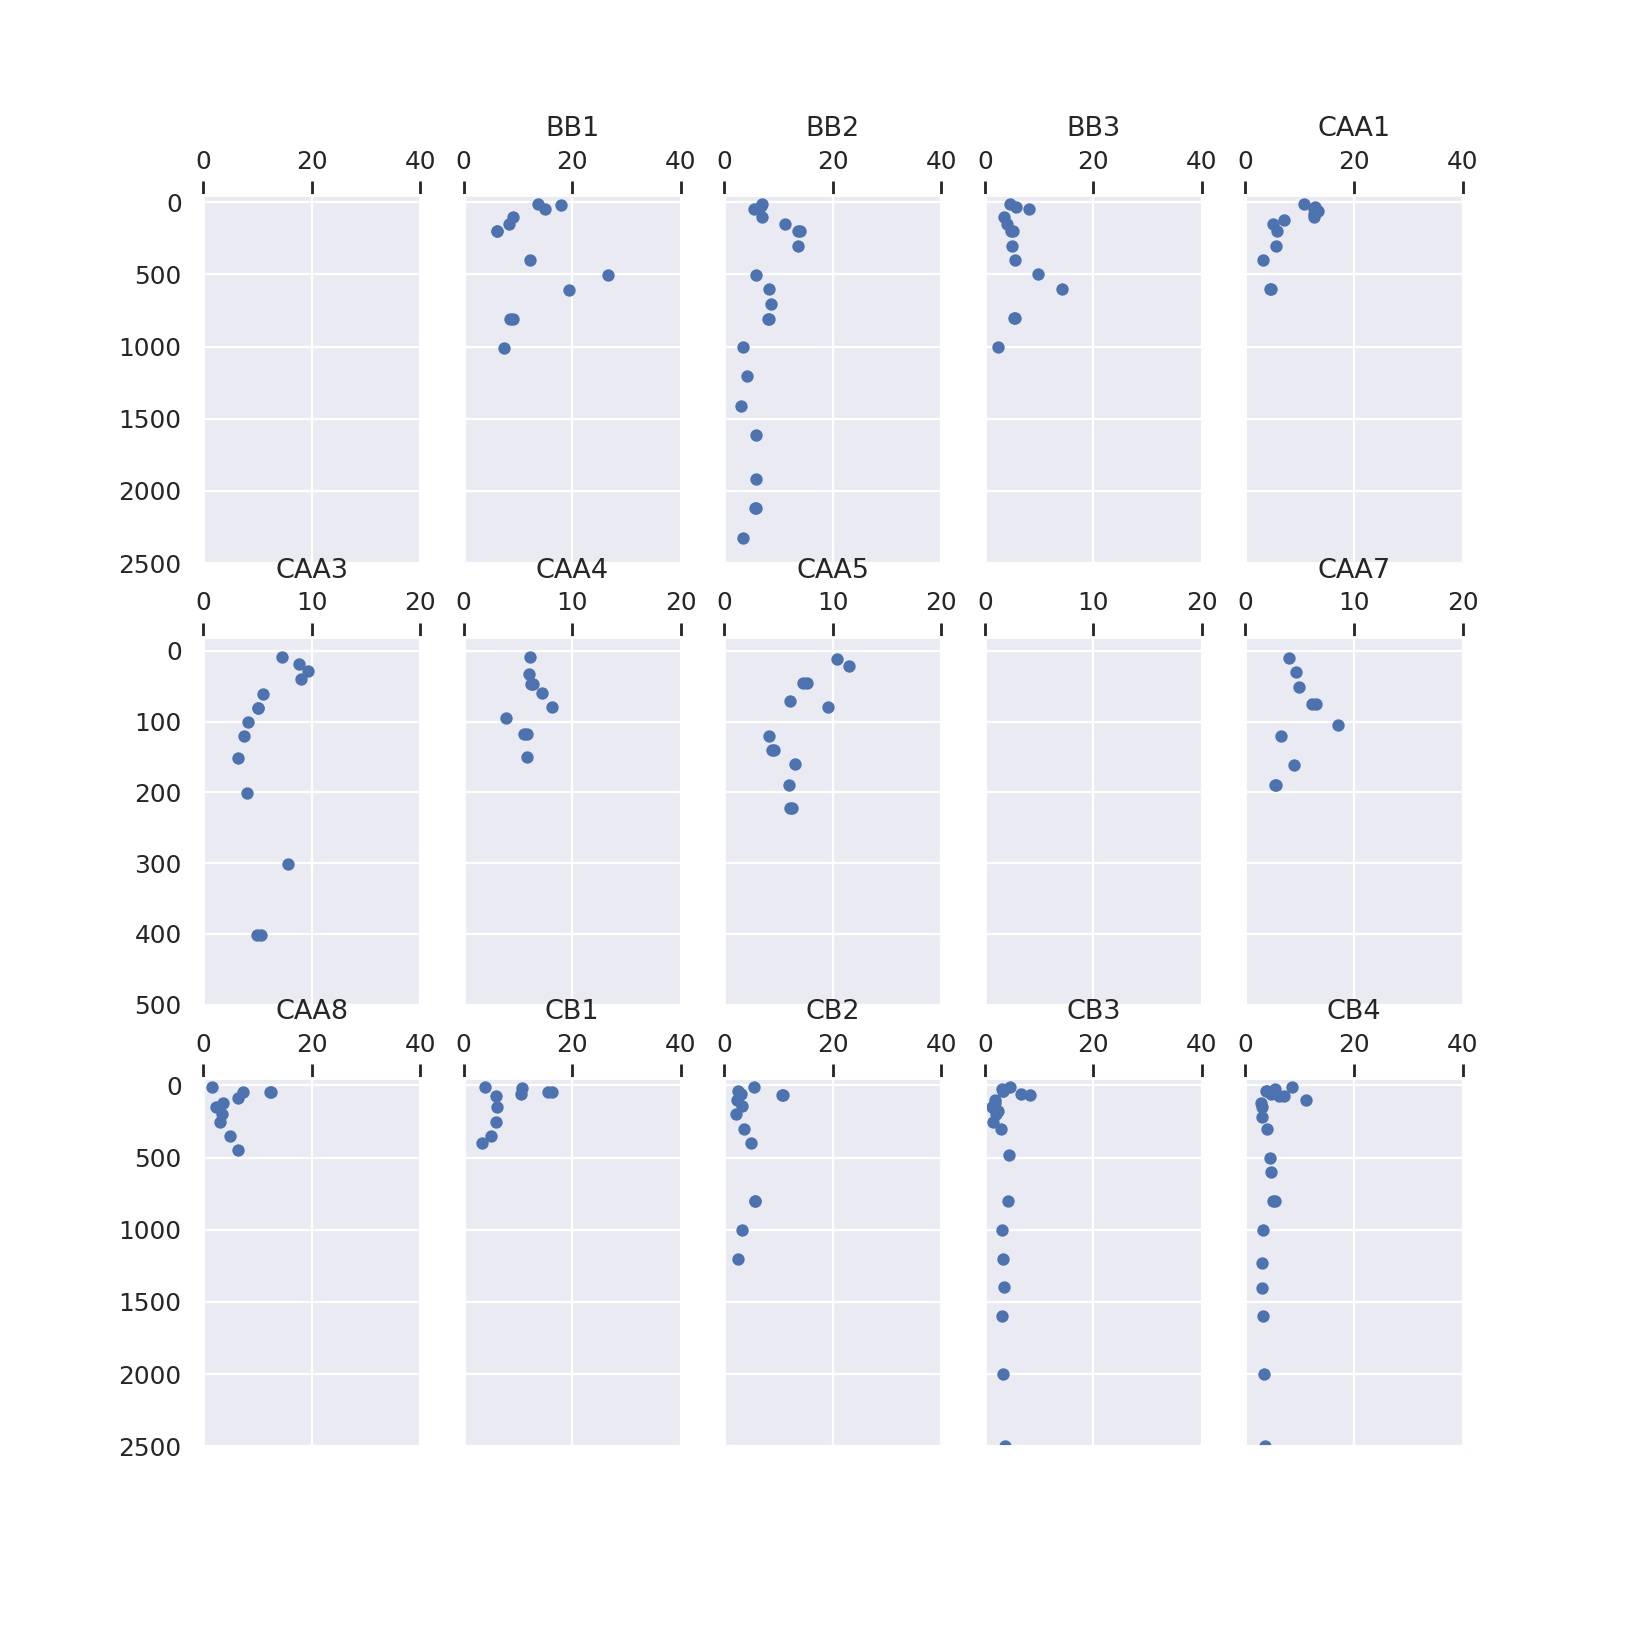

Text(0.5, 1.0, 'CB4')

In [389]:
fig, ax = plt.subplots(3,5, figsize=(10,10))

for row in [0,1,2]:
    for column in [0,1,2,3,4]:
        ax[row, column].invert_yaxis()
        ax[row, column].xaxis.tick_top()
        ax[row, column].set_xlim(0,40)
        ax[row, column].set_ylim(2500, -50)
        if row == 1:
            ax[row, column].set_ylim(500, -20)
            ax[row, column].set_xlim(0, 20)
        if column != 0:
            ax[row, column].set_yticklabels([])
        

# ax[0,0].scatter(dPb_LS2*1e3, depth_LS2, s=20)
ax[0,1].scatter(dPb_BB1*1e3, depth_BB1, s=20)
ax[0,2].scatter(dPb_BB2*1e3, depth_BB2, s=20)
ax[0,3].scatter(dPb_BB3*1e3, depth_BB3, s=20)
ax[0,4].scatter(dPb_CAA1*1e3, depth_CAA1, s=20)
# ax[0,0].set_title("LS2")
ax[0,1].set_title("BB1")
ax[0,2].set_title("BB2")
ax[0,3].set_title("BB3")
ax[0,4].set_title("CAA1")

ax[1,0].scatter(dPb_CAA3*1e3, depth_CAA3, s=20)
ax[1,1].scatter(dPb_CAA4*1e3, depth_CAA4, s=20)
ax[1,2].scatter(dPb_CAA5*1e3, depth_CAA5, s=20)
# ax[1,3].scatter(dPb_CAA6*1e3, depth_CAA6, s=20)
ax[1,4].scatter(dPb_CAA7*1e3, depth_CAA7, s=20)
ax[1,0].set_title("CAA3")
ax[1,1].set_title("CAA4")
ax[1,2].set_title("CAA5")
# ax[1,3].set_title("CAA6")
ax[1,4].set_title("CAA7")

ax[2,0].scatter(dPb_CAA8*1e3, depth_CAA8, s=20)
ax[2,1].scatter(dPb_CB1*1e3,  depth_CB1,  s=20)
ax[2,2].scatter(dPb_CB2*1e3,  depth_CB2,  s=20)
ax[2,3].scatter(dPb_CB3*1e3,  depth_CB3,  s=20)
ax[2,4].scatter(dPb_CB4*1e3,  depth_CB4,  s=20)
ax[2,0].set_title("CAA8")
ax[2,1].set_title("CB1")
ax[2,2].set_title("CB2")
ax[2,3].set_title("CB3")
ax[2,4].set_title("CB4")

In [10]:
POCdata  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/POC&PON_Data_GN02-GN03.csv')
POC_data = POCdata.replace(r'< LOD', 0)

In [11]:
POC_stns = [POC_data['LS2'][1:].dropna().values.astype('float'), \
            POC_data['BB1'][1:].dropna().values.astype('float'), \
            POC_data['BB2'][1:].dropna().values.astype('float'), \
            POC_data['BB3'][1:].dropna().values.astype('float'), \
            POC_data['CAA1'][1:].dropna().values.astype('float'), \
            POC_data['CAA3'][1:].dropna().values.astype('float'), \
            POC_data['CAA4'][1:].dropna().values.astype('float'), \
            POC_data['CAA5'][1:].dropna().values.astype('float'), \
            POC_data['CAA6'][1:].dropna().values.astype('float'), \
            POC_data['CAA7'][1:].dropna().values.astype('float'), \
            POC_data['CAA8'][1:].dropna().values.astype('float'), \
            POC_data['CB1'][1:].dropna().values.astype('float'), \
            POC_data['CB2'][1:].dropna().values.astype('float'), \
            POC_data['CB3'][1:].dropna().values.astype('float'), \
            POC_data['CB4'][1:].dropna().values.astype('float')]

depths_POC = [POC_data['Depth.1'][1:].dropna().values.astype('float'), \
              POC_data['Depth.2'][1:].dropna().values.astype('float'), \
              POC_data['Depth.3'][1:].dropna().values.astype('float'), \
              POC_data['Depth.4'][1:].dropna().values.astype('float'), \
              POC_data['Depth.5'][1:].dropna().values.astype('float'),\
              POC_data['Depth.6'][1:].dropna().values.astype('float'), \
              POC_data['Depth.7'][1:].dropna().values.astype('float'), \
              POC_data['Depth.8'][1:].dropna().values.astype('float'), \
              POC_data['Depth.9'][1:].dropna().values.astype('float'), \
              POC_data['Depth.10'][1:].dropna().values.astype('float'), \
              POC_data['Depth.11'][1:].dropna().values.astype('float'), \
              POC_data['Depth.12'][1:].dropna().values.astype('float'), \
              POC_data['Depth.13'][1:].dropna().values.astype('float'), \
              POC_data['Depth.14'][1:].dropna().values.astype('float'), \
              POC_data['Depth.15'][1:].dropna().values.astype('float')]

POC_names = np.concatenate((['LS2' for i in POC_data['LS2'][1:].dropna()], \
                            ['BB1' for i in POC_data['BB1'][1:].dropna()], \
                            ['BB2' for i in POC_data['BB2'][1:].dropna()], \
                            ['BB3' for i in POC_data['BB3'][1:].dropna()], \
                            ['CAA1' for i in POC_data['CAA1'][1:].dropna()], \
                            ['CAA3' for i in POC_data['CAA3'][1:].dropna()], \
                            ['CAA4' for i in POC_data['CAA4'][1:].dropna()], \
                            ['CAA5' for i in POC_data['CAA5'][1:].dropna()], \
                            ['CAA6' for i in POC_data['CAA6'][1:].dropna()], \
                            ['CAA7' for i in POC_data['CAA7'][1:].dropna()], \
                            ['CAA8' for i in POC_data['CAA8'][1:].dropna()], \
                            ['CB1' for i in POC_data['CB1'][1:].dropna()], \
                            ['CB2' for i in POC_data['CB2'][1:].dropna()], \
                            ['CB3' for i in POC_data['CB3'][1:].dropna()], \
                            ['CB4' for i in POC_data['CB4'][1:].dropna()]))

POC_depths = np.concatenate(depths_POC).ravel()
POC_observ = np.concatenate(POC_stns).ravel()

In [12]:
POC_BB1 = POC_stns[1];   POC_BB2 = POC_stns[2];  POC_BB3 = POC_stns[3];
POC_CAA1 = POC_stns[4];  POC_CAA3 = POC_stns[5]; POC_CAA4 = POC_stns[6];
POC_CAA5 = POC_stns[7];  POC_CAA6 = POC_stns[8]; POC_CAA7 = POC_stns[9];
POC_CAA8 = POC_stns[10]; POC_CB1 = POC_stns[11]; POC_CB2 = POC_stns[12];
POC_CB3 = POC_stns[13];  POC_CB4 = POC_stns[14];

depth_POC_BB1  = depths_POC[1];   depth_POC_BB2  = depths_POC[2];  depth_POC_BB3  = depths_POC[3];
depth_POC_CAA1 = depths_POC[4];   depth_POC_CAA3 = depths_POC[5];  depth_POC_CAA4 = depths_POC[6];
depth_POC_CAA5 = depths_POC[7];   depth_POC_CAA6 = depths_POC[8];  depth_POC_CAA7 = depths_POC[9];
depth_POC_CAA8 = depths_POC[10];  depth_POC_CB1  = depths_POC[11]; depth_POC_CB2  = depths_POC[12];
depth_POC_CB3  = depths_POC[13];  depth_POC_CB4  = depths_POC[14];

Calculate the difference between the surface maximum and the bottom average values.

In [13]:
# Remove: LS2, BB1, BB3, CAA6

drop_CB1 = np.max(dPb_CB1[depth_CB1 < 100]) - np.mean(dPb_CB1[depth_CB1 > 100])
drop_CB2 = np.max(dPb_CB2[depth_CB2 < 100]) - np.mean(dPb_CB2[depth_CB2 > 100])
drop_CB3 = np.max(dPb_CB3[depth_CB3 < 100]) - np.mean(dPb_CB3[depth_CB3 > 100])
drop_CB4 = np.max(dPb_CB4[depth_CB4 < 100]) - np.mean(dPb_CB4[depth_CB4 > 100])

drop_CAA1 = np.max(dPb_CAA1[depth_CAA1 < 100]) - np.mean(dPb_CAA1[depth_CAA1 > 100])
drop_CAA3 = np.max(dPb_CAA3[depth_CAA3 < 100]) - np.mean(dPb_CAA3[depth_CAA3 > 100])
drop_CAA4 = np.max(dPb_CAA4[depth_CAA4 < 100]) - np.mean(dPb_CAA4[depth_CAA4 > 100])
drop_CAA5 = np.max(dPb_CAA5[depth_CAA5 < 100]) - np.mean(dPb_CAA5[depth_CAA5 > 100])
drop_CAA7 = np.max(dPb_CAA7[depth_CAA7 < 100]) - np.mean(dPb_CAA7[depth_CAA7 > 100])
drop_CAA8 = np.max(dPb_CAA8[depth_CAA8 < 100]) - np.mean(dPb_CAA8[depth_CAA8 > 100])

drop_BB2 = np.max(dPb_BB2[depth_BB2 < 100]) - np.mean(dPb_BB2[depth_BB2 > 100])

In [15]:
POC_mean_CB1 = np.mean(POC_CB1[depth_POC_CB1 < 100])
POC_mean_CB2 = np.mean(POC_CB2[depth_POC_CB2 < 100])
POC_mean_CB3 = np.mean(POC_CB3[depth_POC_CB3 < 100])
POC_mean_CB4 = np.mean(POC_CB4[depth_POC_CB4 < 100])

POC_mean_CAA1 = np.mean(POC_CAA1[depth_POC_CAA1 < 100])
POC_mean_CAA3 = np.mean(POC_CAA3[depth_POC_CAA3 < 100])
POC_mean_CAA4 = np.mean(POC_CAA4[depth_POC_CAA4 < 100])
POC_mean_CAA5 = np.mean(POC_CAA5[depth_POC_CAA5 < 100])
POC_mean_CAA7 = np.mean(POC_CAA7[depth_POC_CAA7 < 100])
POC_mean_CAA8 = np.mean(POC_CAA8[depth_POC_CAA8 < 100])

POC_mean_BB2 = np.mean(POC_BB2[depth_POC_BB2 < 100])

<IPython.core.display.Javascript object>


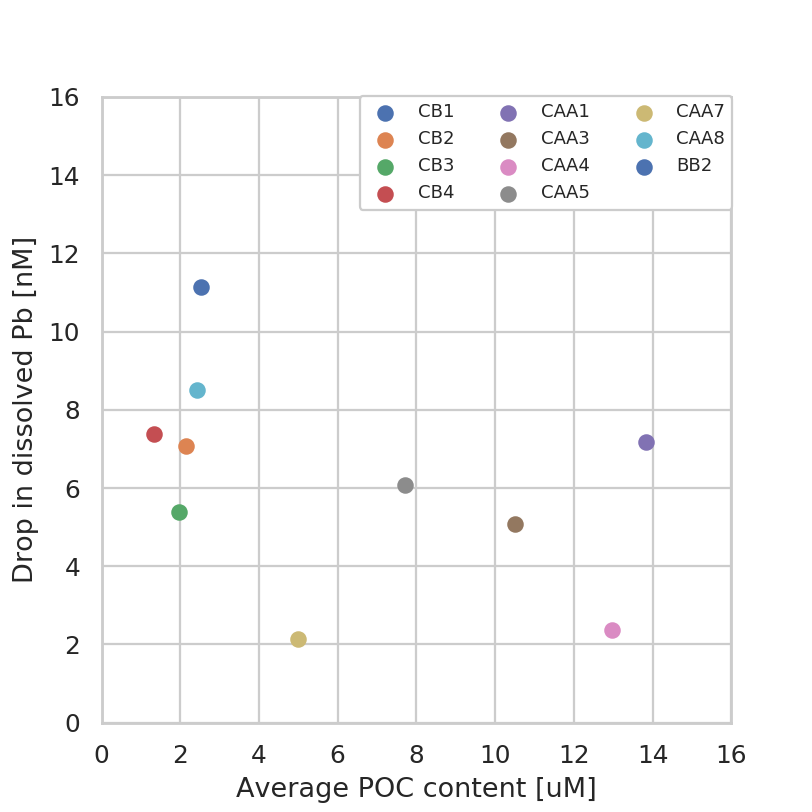

In [33]:
with sns.axes_style('whitegrid'):

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    ax.scatter(POC_mean_CB1, drop_CB1*1e3, s=40, label='CB1')
    ax.scatter(POC_mean_CB2, drop_CB2*1e3, s=40, label='CB2')
    ax.scatter(POC_mean_CB3, drop_CB3*1e3, s=40, label='CB3')
    ax.scatter(POC_mean_CB4, drop_CB4*1e3, s=40, label='CB4')

    ax.scatter(POC_mean_CAA1, drop_CAA1*1e3, s=40, label='CAA1')
    ax.scatter(POC_mean_CAA3, drop_CAA3*1e3, s=40, label='CAA3')
    ax.scatter(POC_mean_CAA4, drop_CAA4*1e3, s=40, label='CAA4')
    ax.scatter(POC_mean_CAA5, drop_CAA5*1e3, s=40, label='CAA5')
    ax.scatter(POC_mean_CAA7, drop_CAA7*1e3, s=40, label='CAA7')
    ax.scatter(POC_mean_CAA8, drop_CAA8*1e3, s=40, label='CAA8')
    ax.scatter(POC_mean_BB2, drop_BB2*1e3, s=40, label='BB2')

    ax.legend(loc=(0.41, 0.82), ncol=3, fontsize=8, framealpha=1)
    ax.set_xlim(0,16)
    ax.set_ylim(0,16)
    ax.set_ylabel('Drop in dissolved Pb [nM]')
    ax.set_xlabel('Average POC content [uM]')
    
    fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/scavenging-param1.png', dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


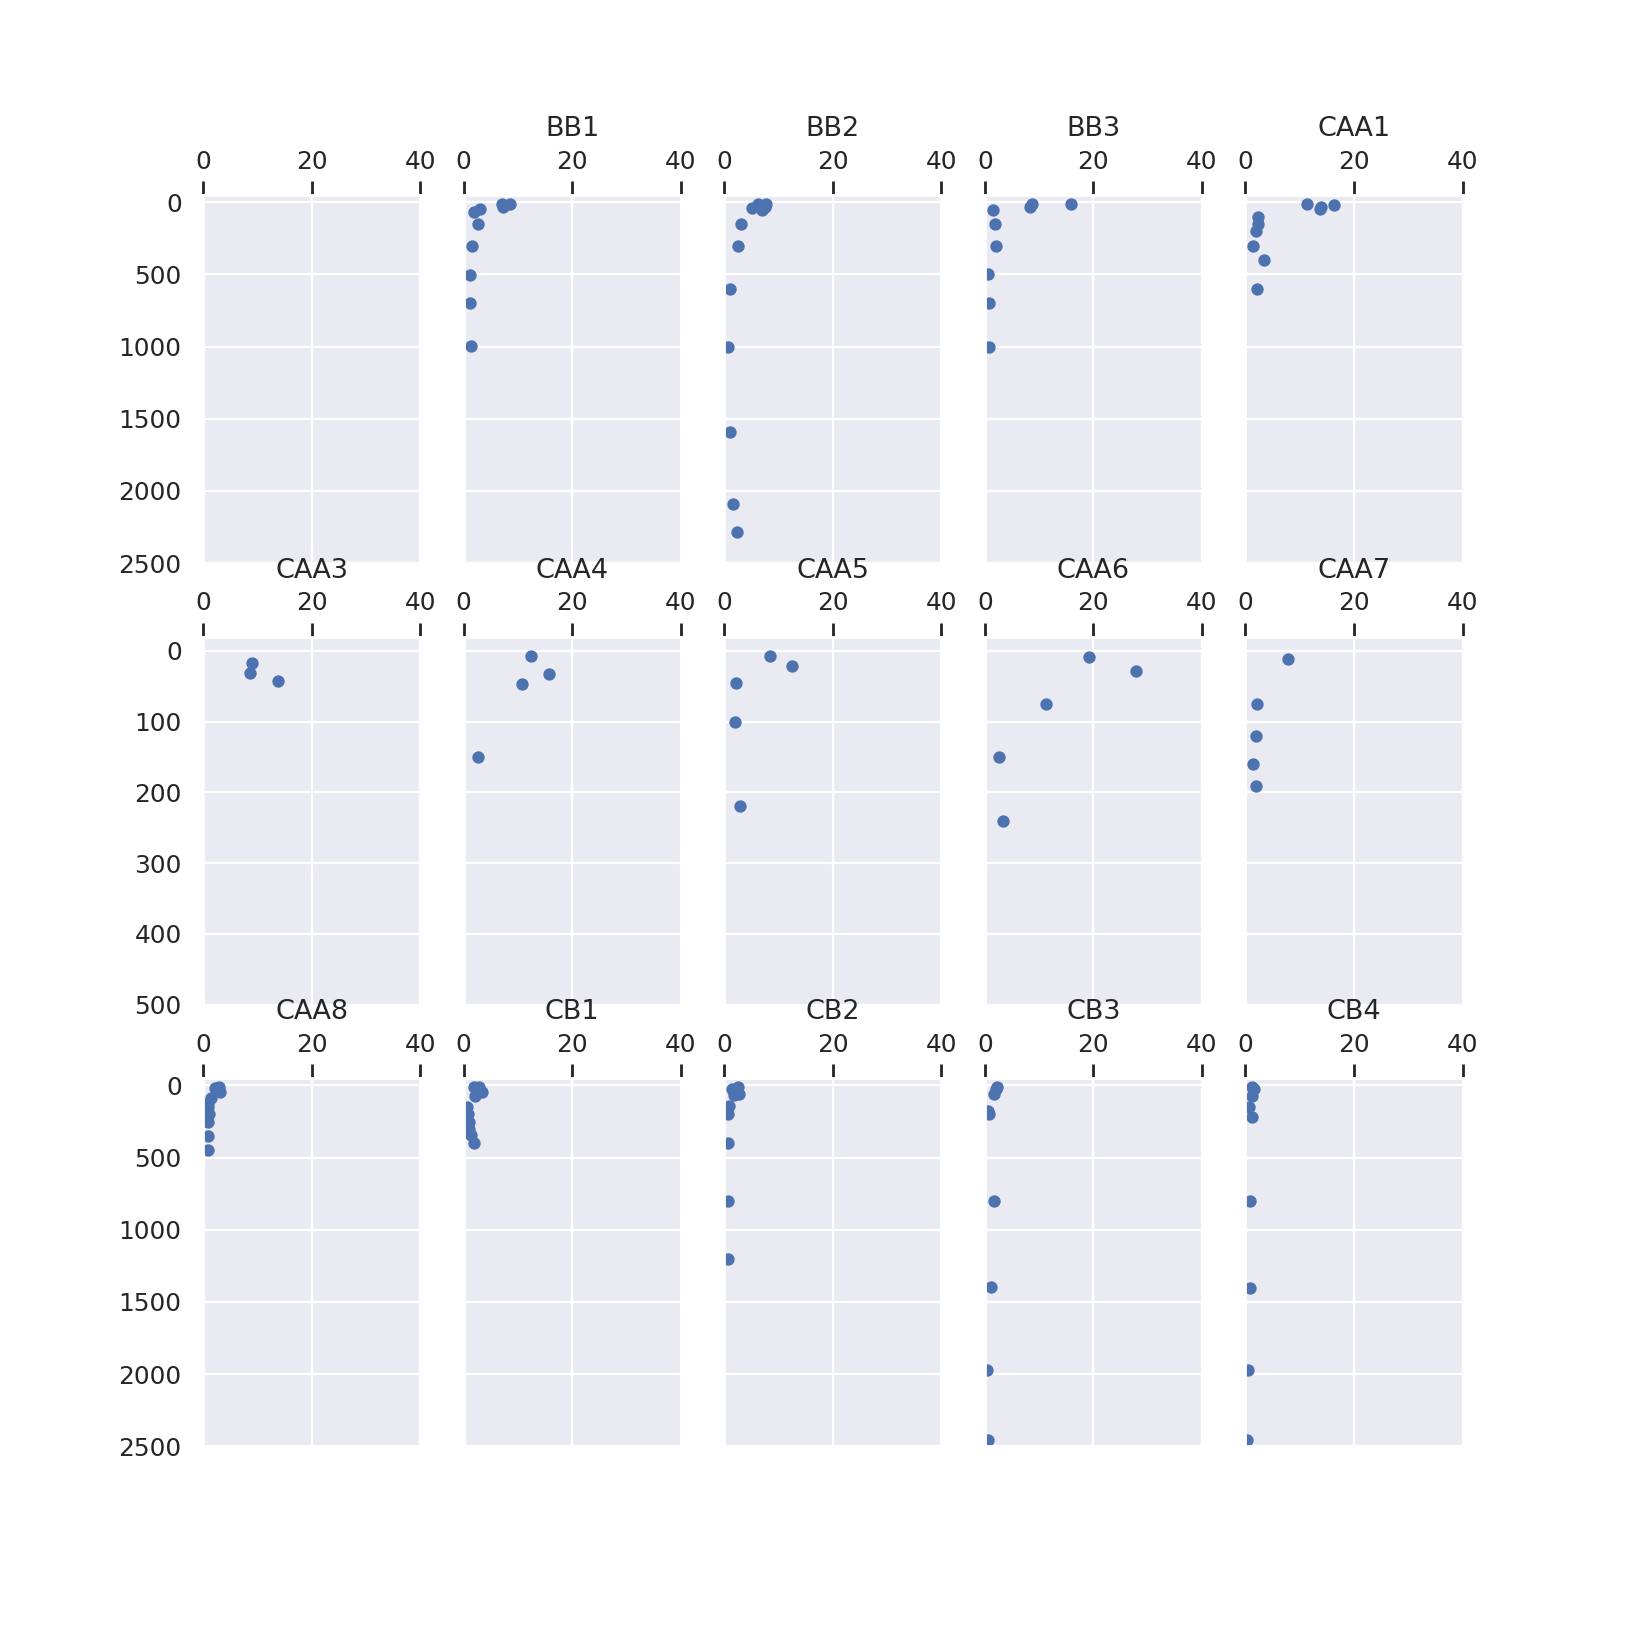

Text(0.5, 1.0, 'CB4')

In [429]:
fig, ax = plt.subplots(3,5, figsize=(10,10))

for row in [0,1,2]:
    for column in [0,1,2,3,4]:
        ax[row, column].invert_yaxis()
        ax[row, column].xaxis.tick_top()
        ax[row, column].set_xlim(0,40)
        ax[row, column].set_ylim(2500, -50)
        if row == 1:
            ax[row, column].set_ylim(500, -20)
            ax[row, column].set_xlim(0, 40)
        if column != 0:
            ax[row, column].set_yticklabels([])
        

# ax[0,0].scatter(POC_LS2, depth_POC_LS2, s=20)
ax[0,1].scatter(POC_BB1, depth_POC_BB1, s=20)
ax[0,2].scatter(POC_BB2, depth_POC_BB2, s=20)
ax[0,3].scatter(POC_BB3, depth_POC_BB3, s=20)
ax[0,4].scatter(POC_CAA1, depth_POC_CAA1, s=20)
# ax[0,0].set_title("LS2")
ax[0,1].set_title("BB1")
ax[0,2].set_title("BB2")
ax[0,3].set_title("BB3")
ax[0,4].set_title("CAA1")

ax[1,0].scatter(POC_CAA3, depth_POC_CAA3, s=20)
ax[1,1].scatter(POC_CAA4, depth_POC_CAA4, s=20)
ax[1,2].scatter(POC_CAA5, depth_POC_CAA5, s=20)
ax[1,3].scatter(POC_CAA6, depth_POC_CAA6, s=20)
ax[1,4].scatter(POC_CAA7, depth_POC_CAA7, s=20)
ax[1,0].set_title("CAA3")
ax[1,1].set_title("CAA4")
ax[1,2].set_title("CAA5")
ax[1,3].set_title("CAA6")
ax[1,4].set_title("CAA7")

ax[2,0].scatter(POC_CAA8, depth_POC_CAA8, s=20)
ax[2,1].scatter(POC_CB1,  depth_POC_CB1,  s=20)
ax[2,2].scatter(POC_CB2,  depth_POC_CB2,  s=20)
ax[2,3].scatter(POC_CB3,  depth_POC_CB3,  s=20)
ax[2,4].scatter(POC_CB4,  depth_POC_CB4,  s=20)
ax[2,0].set_title("CAA8")
ax[2,1].set_title("CB1")
ax[2,2].set_title("CB2")
ax[2,3].set_title("CB3")
ax[2,4].set_title("CB4")

#### Functions

In [34]:
def assoc_depth(depth_Pb, depth_POC):
    
    # find depths that are in common
    common_depths = np.empty_like(depth_POC)
    index_depths  = np.empty_like(depth_POC)
    
    i=0
    for depth in depth_POC:
        min_val  = np.argmin(np.abs(depth_Pb - depth))
        if np.abs(depth_Pb[min_val] - depth) > 50:
            common_depths[i] = np.nan
            index_depths[i]  = np.nan
        else:
            common_depths[i] = depth_Pb[min_val]
            index_depths[i]  = min_val
        i+=1
        
    return common_depths, index_depths

### Dissolved Pb vs. POC

In [35]:
common_depths, z_index = assoc_depth(obs_depths, POC_depths)

ind_nan = np.argwhere(np.isnan(z_index))
z_index[ind_nan] = 0

In [36]:
Pb_observ = [obs_dPb[int(z)] for z in z_index]
Pb_observ[int(ind_nan)] = np.nan

In [37]:
# Mask places where depths are too different:
dPb_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_observ), np.isnan(Pb_observ)), Pb_observ)
POC_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_observ), np.isnan(Pb_observ)), POC_observ)

<IPython.core.display.Javascript object>


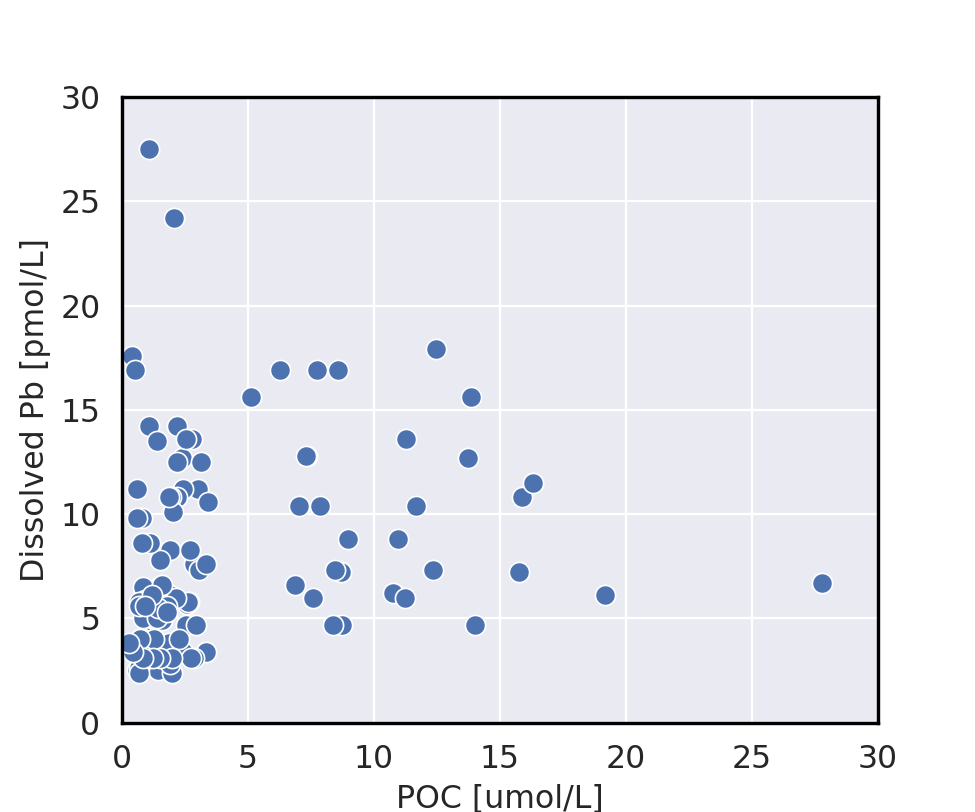

In [165]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
st = sns.axes_style("whitegrid")

with st:
    ax.set(ylim=(0,30.0), xlim=(0,30.0))
    
    sns.scatterplot(POC_masked, dPb_masked*1e3, s=80)
    
    ax.set_ylabel('Dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('POC [umol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

POC drop metric:

In [73]:
def calc_drop(stn_name):
    
    # indices of station for POC
    POC_indices = np.argwhere(POC_names==stn_name)
    Pb_indices  = np.argwhere(obs_names==stn_name)
    
    POC = POC_observ[POC_indices]
    Pb  = obs_dPb[Pb_indices]
    POC_depth = POC_depths[POC_indices]
    Pb_depth  = obs_depths[Pb_indices]
    
    POC_drop = np.ma.mean(POC[POC_depth < 50]) - np.ma.mean(POC[POC_depth > 50])
    Pb_drop  = np.ma.mean(Pb[Pb_depth < 50])   - np.ma.mean(Pb[Pb_depth > 50])
    
    return POC_drop, Pb_drop

In [74]:
POC_drops = []
Pb_drops  = []
for stn in stn_names[1:]:
    POC_stn, Pb_stn = calc_drop(stn)
    POC_drops.append(POC_stn)
    Pb_drops.append(Pb_stn)
    
POC_drop = np.array(POC_drops)
Pb_drop = np.array(Pb_drops)

POC_drop_masked = np.ma.masked_where(np.logical_or(np.isnan(POC_drop), np.isnan(Pb_drop)), POC_drop)
Pb_drop_masked  = np.ma.masked_where(np.logical_or(np.isnan(POC_drop), np.isnan(Pb_drop)), Pb_drop)

In [75]:
cmap_CB  = sns.color_palette("Blues", 4)
cmap_BB  = sns.color_palette("Reds", 3)
cmap_CAA = sns.color_palette("BrBG", 9)   

<IPython.core.display.Javascript object>


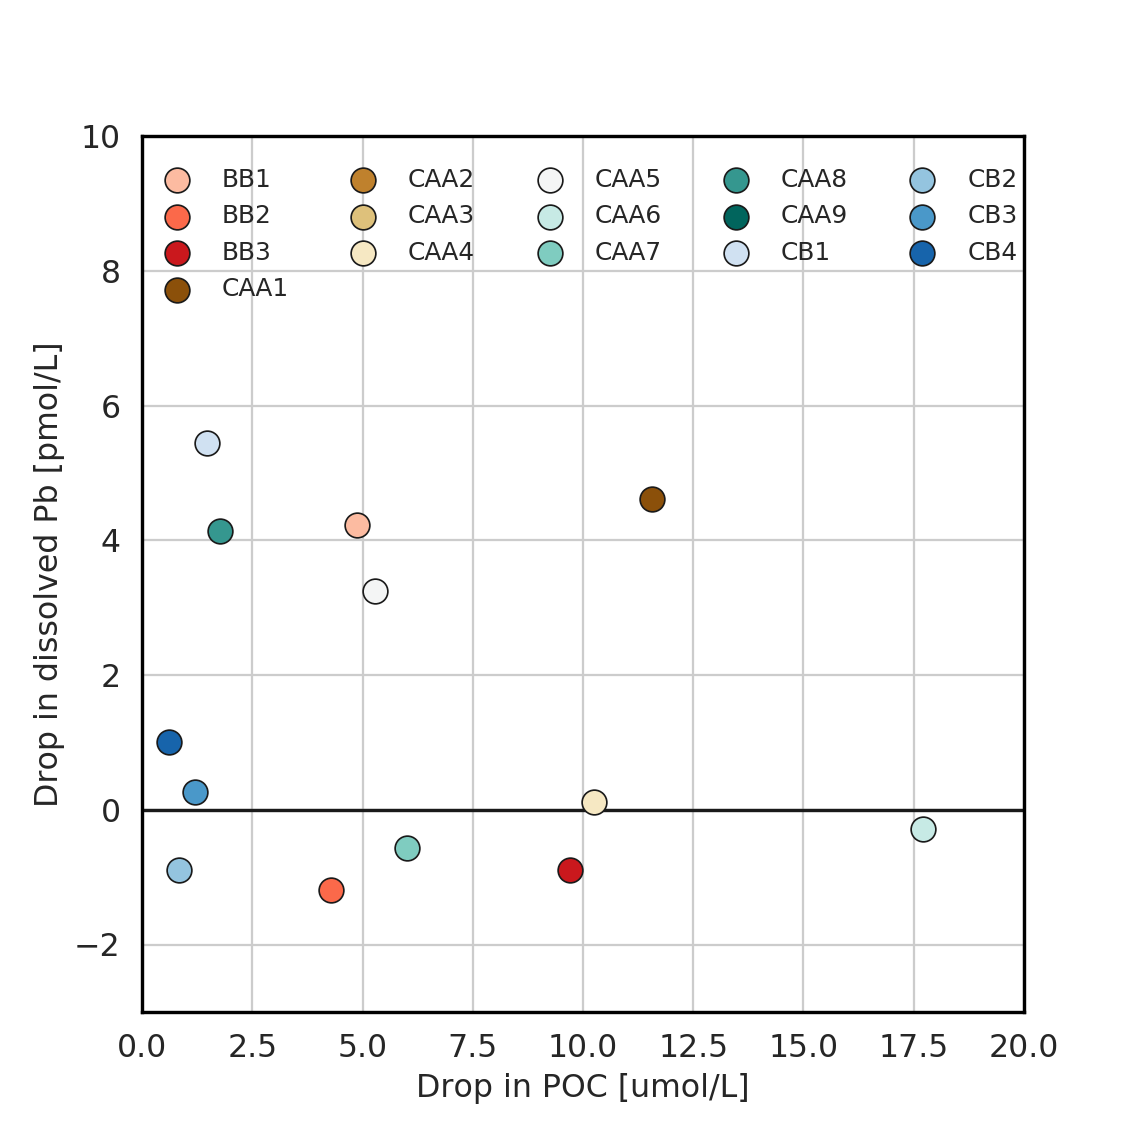

In [78]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    sns.lineplot([0, 100], [0, 0], c='k')
    
    i=0
    nBB = 0; nCB = 0; nCAA = 0;
    for stn in stn_names[1:]:
        if stn[0:2]=='BB':
            sns.scatterplot([POC_drop_masked[i]], [Pb_drop_masked[i]*1e3], ax=ax, color=cmap_BB[nBB], s=120, \
                            zorder=3, label=stn, edgecolor='k')
            nBB+=1
        elif stn[0:2]=='CB':
            sns.scatterplot([POC_drop_masked[i]], [Pb_drop_masked[i]*1e3], ax=ax, color=cmap_CB[nCB], s=120, \
                            zorder=3, label=stn, edgecolor='k')
            nCB+=1
        elif stn[0:2]=='CA':
            sns.scatterplot([POC_drop_masked[i]], [Pb_drop_masked[i]*1e3], ax=ax, color=cmap_CAA[nCAA], s=120, \
                            zorder=3, label=stn, edgecolor='k')
            nCAA+=1
        i+=1
        
    ax.set_ylabel('Drop in dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Drop in POC [umol/L]', fontsize=14)
    ax.legend(loc=(0.0, 0.8), ncol=5, frameon=False)
    ax.set(ylim=(-3,10), xlim=(0,20.0))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/scavenging-param3.png', dpi=300, bbox_inches='tight')

Drop in dissolved Pb over sections of depth versus average POC concentration at those depths:

In [41]:
stn_name='BB1'

POC_indices = np.argwhere(POC_names==stn_name)
Pb_indices  = np.argwhere(obs_names==stn_name)

In [42]:
POC_depth = POC_depths[POC_indices]
Pb_depth  = obs_depths[Pb_indices]

In [66]:
def calc_drop_in_chunks(stn_name):
    
    # indices of station
    POC_indices = np.argwhere(POC_names==stn_name)
    Pb_indices  = np.argwhere(obs_names==stn_name)
    
    # Data at that station:
    POC = POC_observ[POC_indices]
    Pb  = obs_dPb[Pb_indices]
    POC_depth = POC_depths[POC_indices]
    Pb_depth  = obs_depths[Pb_indices]
    
    # Estimate the drop over chunks of depth:
    chunk      = 30
    num_chunks = np.int(np.floor(np.divide(np.min([np.max(Pb_depth), np.max(POC_depth)]),chunk)))
    
    Pb_drop_ch = []; POC_ch = [];
    for i in range(1,num_chunks):
        Pb_drop_chunk = np.ma.mean(Pb[(Pb_depth > chunk*(int(i-1))) & (Pb_depth < chunk*int(i))]) - \
                        np.ma.mean(Pb[(Pb_depth > chunk*int(i))     & (Pb_depth < chunk*(int(i+1)))])
        POC_chunk     = np.ma.mean(POC[(POC_depth > chunk*int(i))   & (POC_depth < chunk*(int(i+1)))])
        
        Pb_drop_ch.append(Pb_drop_chunk)
        POC_ch.append(POC_chunk)

    Pb_drops  = np.array(Pb_drop_ch)
    POC_means = np.array(POC_ch)
    return Pb_drops, POC_means

In [67]:
Pb_drops  = []
POC_means = []
lst_names = []

for stn in stn_names[1:]:
    try:
        Pb_drops_stn, POC_means_stn = calc_drop_in_chunks(stn)
        Pb_drops.append(Pb_drops_stn)
        POC_means.append(POC_means_stn)
        lst_names.append([stn for i in Pb_drops_stn]) # list of names
    except:
        print("Data not available for station: ", stn)

Pb_drop    = np.concatenate(Pb_drops).ravel()
POC_mean   = np.concatenate(POC_means).ravel()
list_names = np.concatenate(lst_names).ravel()

Data not available for station:  CAA2
Data not available for station:  CAA9


In [68]:
POC_mean_masked = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), POC_mean)
Pb_drop_masked  = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), Pb_drop)
names_masked    = np.ma.masked_where(np.logical_or(np.isnan(Pb_drop), np.isnan(POC_mean)), list_names)

print('Number of non-NaN elements in POC mean: ', np.count_nonzero(~np.isnan(POC_mean)))
print('Number of non-NaN elements in Pb drop:  ',np.count_nonzero(~np.isnan(Pb_drop)))

Number of non-NaN elements in POC mean:  69
Number of non-NaN elements in Pb drop:   42


<IPython.core.display.Javascript object>


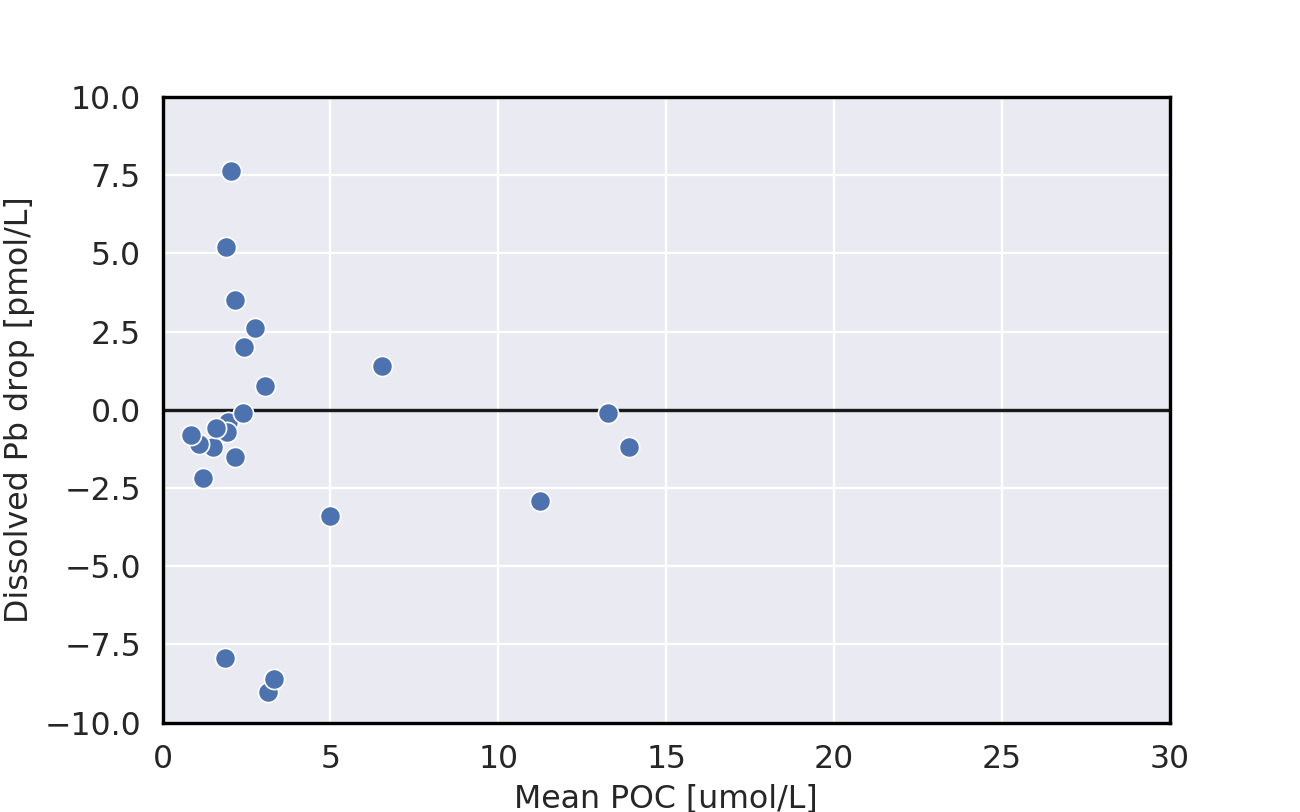

In [69]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
st = sns.axes_style("whitegrid")

with st:
    ax.set(xlim=(0,30.0), ylim=(-10,10))
    sns.lineplot([0, 100], [0, 0], c='k', ax=ax)
    sns.scatterplot(POC_mean_masked, Pb_drop_masked*1e3, s=80, zorder=3, ax=ax)
    
    ax.set_ylabel('Dissolved Pb drop [pmol/L]', fontsize=14)
    ax.set_xlabel('Mean POC [umol/L]', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    

In [321]:
# BB_length  = len(np.concatenate([np.argwhere(names_masked=='BB'+str(i)) for i in range(1,4)]).ravel())
# CB_length  = len(np.concatenate([np.argwhere(names_masked=='CB'+str(i)) for i in range(1,5)]).ravel())
# CAA_length = len(np.concatenate([np.argwhere(names_masked=='CAA'+str(i)) for i in range(1,10)]).ravel())

cmap_CB  = sns.color_palette("Blues", 4)
cmap_BB  = sns.color_palette("Reds",  3)
cmap_CAA = sns.color_palette("BrBG",  7)

<IPython.core.display.Javascript object>


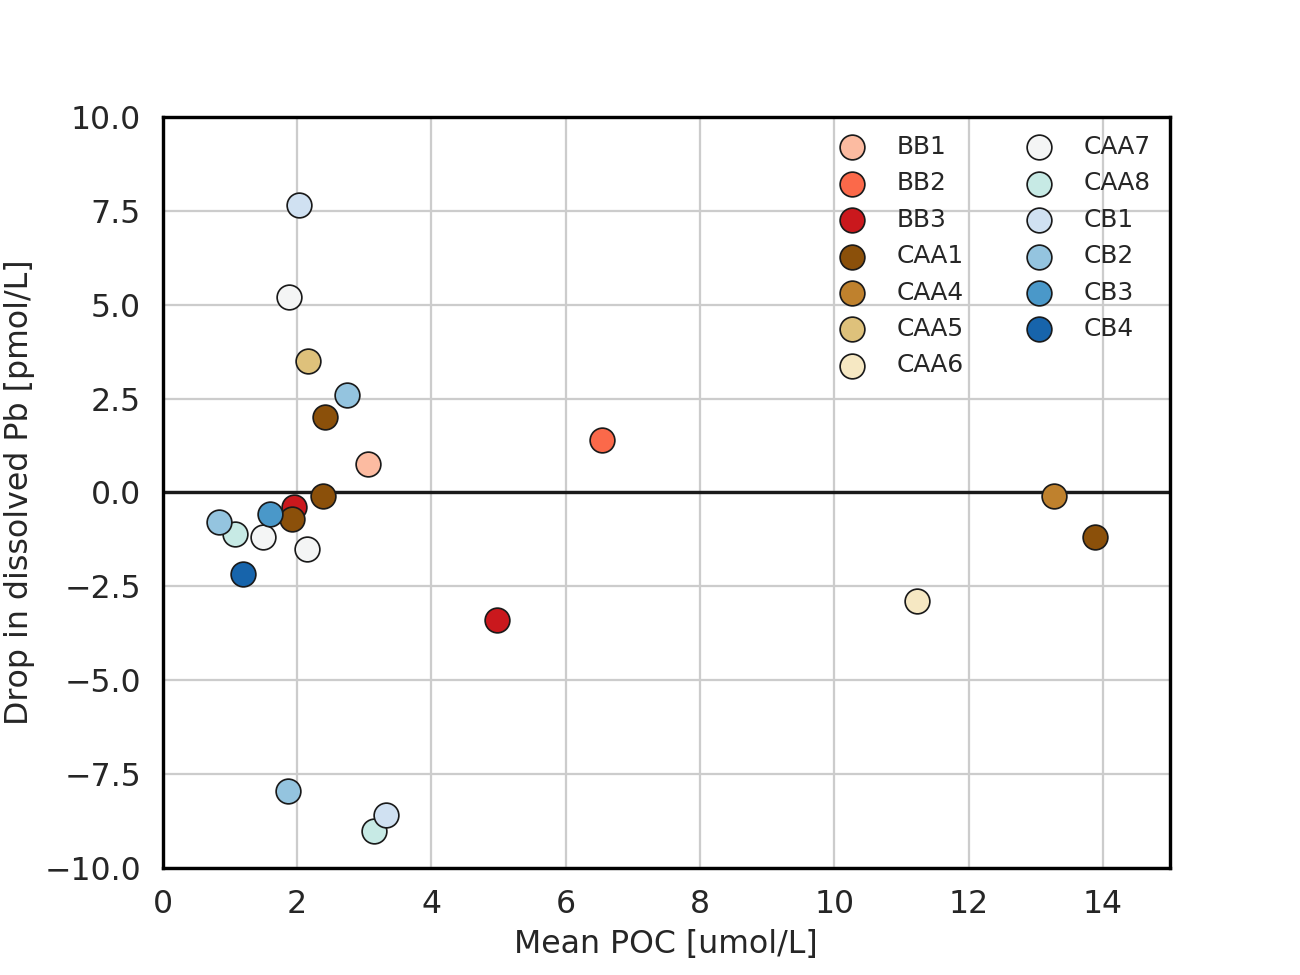

No data available for station:  CAA2
No data available for station:  CAA3
No data available for station:  CAA9


In [72]:
st = sns.axes_style("whitegrid")

with st:
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    sns.lineplot([0, 100], [0, 0], c='k')
    
    nBB = 0; nCB = 0; nCAA = 0;
    for stn in stn_names[1:]:
        
        try:
            stn_indices = np.argwhere(names_masked==stn)
            if len(stn_indices) > 1:
                POC_plot = [POC_mean_masked[i] for i in stn_indices]
                Pb_plot  = [Pb_drop_masked[i]*1e3 for i in stn_indices]
            else:
                POC_plot = [POC_mean_masked[stn_indices]]
                Pb_plot  = [Pb_drop_masked[stn_indices]*1e3]

            if stn[0:2]=='BB':    
                sns.scatterplot(POC_plot, Pb_plot, color=cmap_BB[nBB], s=120, zorder=3, label=stn, edgecolor='k')
                nBB+=1
            elif stn[0:2]=='CB':
                sns.scatterplot(POC_plot, Pb_plot, color=cmap_CB[nCB], s=120, zorder=3, label=stn, edgecolor='k')
                nCB+=1
            elif stn[0:2]=='CA':
                sns.scatterplot(POC_plot, Pb_plot, color=cmap_CAA[nCAA], s=120, zorder=3, label=stn, edgecolor='k')
                nCAA+=1
        except:
            print('No data available for station: ', stn)
        
    ax.set_ylabel('Drop in dissolved Pb [pmol/L]', fontsize=14)
    ax.set_xlabel('Mean POC [umol/L]', fontsize=14)
    ax.legend(loc=(0.65, 0.64), ncol=2, frameon=False)
    ax.set(ylim=(-10,10), xlim=(0,15))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');  
    
    fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/scavenging-param2.png', dpi=300, bbox_inches='tight')